Import necessary libraries and configure the environment.

In [ ]:
# Setup - imports and configuration

import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Add src to path
src_dir = Path('..') / 'src'
sys.path.insert(0, str(src_dir))

# Import utilities
from utils import (
    get_sourcedata_path,
    load_events,
    get_session_runs,
    load_bold
)

# Import RL utilities
from rl_utils import (
    create_simple_proxy_features,
    convolve_with_hrf,
    apply_pca
)

# Import RL visualizations
from rl_viz_utils import (
    plot_pca_variance_per_layer,
    plot_layer_activations_sample
)

# Import encoding utilities
from encoding_utils import (
    load_and_prepare_bold,
    fit_encoding_model_per_layer,
    compare_layer_performance
)

# Import encoding visualizations
from encoding_viz_utils import (
    plot_layer_comparison_bars,
    plot_r2_brainmap
)

# Plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

# Get sourcedata path
sourcedata_path = get_sourcedata_path()

print("✓ Setup complete!")

✓ Setup complete!


## Encoding Model Framework

### The Brain Encoding Problem

**Goal:** Use RL features to predict brain activity

**Model:** Ridge Regression
```
BOLD(voxel, time) = Σ βᵢ · Feature_i(time) + ε
```

**Ridge regression:** Linear regression with L2 regularization
- Handles high-dimensional features (50 components)
- Prevents overfitting
- Cross-validation to select regularization strength (α)

In [ ]:
# Load prerequisites

from nilearn.masking import compute_multi_epi_mask

# Define constants (assumed from the first tutorial)
SUBJECT = 'sub-01'
SESSION = 'ses-010'
TR = 1.49


# Get runs
runs = get_session_runs(SUBJECT, SESSION, sourcedata_path)
print(f"Found {len(runs)} runs: {runs}")

# Load events
all_events = []
for run in runs:
    events = load_events(SUBJECT, SESSION, run, sourcedata_path)
    all_events.append(events)
    print(f"  {run}: {len(events)} events")

# Create common mask (or load from main tutorial)
print("\nCreating common brain mask...")
bold_imgs= []
for run in runs:
    bold_img = load_bold(SUBJECT, SESSION, run, sourcedata_path)
    bold_imgs.append(bold_img)

common_mask = compute_multi_epi_mask(bold_imgs, n_jobs=1)
n_voxels = int((common_mask.get_fdata() > 0).sum())
print(f"✓ Common mask: {n_voxels:,} voxels")

print("\n✓ All prerequisites loaded!")


Found 4 runs: ['run-1', 'run-2', 'run-3', 'run-4']
  run-1: 953 events
  run-2: 986 events
  run-3: 892 events
  run-4: 1033 events

Creating common brain mask...


✓ Common mask: 213,443 voxels

✓ All prerequisites loaded!


Load the CNN activations extracted from the RL agent (from notebook 02).

In [ ]:
# Load activations from 02_reinforcement_learning.ipynb
import pickle
from pathlib import Path

activations_file = Path('../derivatives/activations/reduced_activations.pkl')

if activations_file.exists():
    with open(activations_file, 'rb') as f:
        reduced_activations = pickle.load(f)
    
    print("✓ Loaded pre-computed activations")
    print(f"  Layers: {list(reduced_activations.keys())}")
    for layer, acts in reduced_activations.items():
        print(f"  {layer}: {acts.shape}")
else:
    print(f"✗ Activations file not found: {activations_file}")
    print("\nPlease run 02_reinforcement_learning.ipynb first to extract CNN activations.")
    print("Alternatively, you can use proxy features for testing:")
    print("  (but results won't be meaningful)")
    
    # Create minimal proxy for testing
    import numpy as np
    np.random.seed(42)
    total_trs = sum(len(bold_img.get_fdata()[0,0,0,:]) for bold_img in bold_imgs)
    
    reduced_activations = {}
    for layer in ['conv1', 'conv2', 'conv3', 'conv4', 'linear']:
        reduced_activations[layer] = np.random.randn(total_trs, 50)
    
    print("\n⚠ Using random proxy features (not meaningful!)")


✓ Loaded pre-computed activations
  Layers: ['conv1', 'conv2', 'conv3', 'conv4', 'linear']
  conv1: (1000, 50)
  conv2: (1000, 50)
  conv3: (1000, 50)
  conv4: (1000, 50)
  linear: (1000, 50)


Import necessary libraries and configure the environment.

In [ ]:
# Clean and prepare BOLD data

from encoding_utils import load_and_prepare_bold

print("Cleaning BOLD (detrending, standardizing)...\n")

bold_data = load_and_prepare_bold(
    bold_imgs,
    mask_img=common_mask,
    confounds_list=None,  # Already cleaned in GLM
    detrend=True,
    standardize=True,
    high_pass=1/128,
    t_r=TR
)

print(f"✓ BOLD prepared:")
print(f"  Shape: {bold_data.shape}")
print(f"  Timepoints: {bold_data.shape[0]}")
print(f"  Voxels: {bold_data.shape[1]:,}")

Cleaning BOLD (detrending, standardizing)...



✓ BOLD prepared:
  Shape: (1799, 213443)
  Timepoints: 1799
  Voxels: 213,443


Display information about the current step.

In [ ]:
# Align timepoints between BOLD and activations

n_bold = bold_data.shape[0]
n_acts = list(reduced_activations.values())[0].shape[0]

print(f"BOLD timepoints: {n_bold}")
print(f"Activations timepoints: {n_acts}")

# Take minimum (align)
n_time = min(n_bold, n_acts)

bold_data = bold_data[:n_time]
for layer in reduced_activations.keys():
    reduced_activations[layer] = reduced_activations[layer][:n_time]

print(f"\n✓ Aligned to {n_time} timepoints")

BOLD timepoints: 1799
Activations timepoints: 1000

✓ Aligned to 1000 timepoints


Display information about the current step.

In [ ]:
# Create train/test split (80/20)

n_train = int(n_time * 0.8)
train_idx = np.arange(n_train)
test_idx = np.arange(n_train, n_time)

print(f"Train/test split:")
print(f"  Train: {len(train_idx)} timepoints")
print(f"  Test: {len(test_idx)} timepoints")

Train/test split:
  Train: 800 timepoints
  Test: 200 timepoints


Import necessary libraries and configure the environment.

In [ ]:
%%time
# Fit ridge regression encoding models

from encoding_utils import fit_encoding_model_per_layer

alphas = [0.1, 1, 10, 100, 1000, 10000, 100000]

print("Fitting ridge regression (5 layers × voxels)...")
print("This takes ~3-5 minutes\n")

encoding_results = fit_encoding_model_per_layer(
    reduced_activations, 
    bold_data, 
    common_mask,
    train_idx, 
    test_idx, 
    alphas=alphas
)

print("\n✓ Encoding complete!")

Fitting ridge regression (5 layers × voxels)...
This takes ~3-5 minutes

Fitting encoding model for layer: conv1


  Best alpha: 100000.0
  Mean R² (train): 0.0015
  Mean R² (test): -0.0030

Fitting encoding model for layer: conv2


  Best alpha: 100000.0
  Mean R² (train): 0.0015
  Mean R² (test): -0.0030

Fitting encoding model for layer: conv3


  Best alpha: 100000.0
  Mean R² (train): 0.0012
  Mean R² (test): -0.0029

Fitting encoding model for layer: conv4


  Best alpha: 100000.0
  Mean R² (train): 0.0013
  Mean R² (test): -0.0030

Fitting encoding model for layer: linear


  Best alpha: 100000.0
  Mean R² (train): 0.0013
  Mean R² (test): -0.0029


✓ Encoding complete!
CPU times: user 21min 32s, sys: 1min 22s, total: 22min 55s
Wall time: 6min


Import necessary libraries and configure the environment.

Layer Performance:

 layer   mean_r2   max_r2  median_r2  n_positive_voxels
linear -0.002915 0.002583  -0.001470              22202
 conv3 -0.002928 0.002969  -0.001500              23062
 conv1 -0.002952 0.003519  -0.001553              23604
 conv2 -0.002954 0.003781  -0.001546              23060
 conv4 -0.002958 0.002693  -0.001535              22116

⭐ Best: LINEAR (R² = -0.0029)


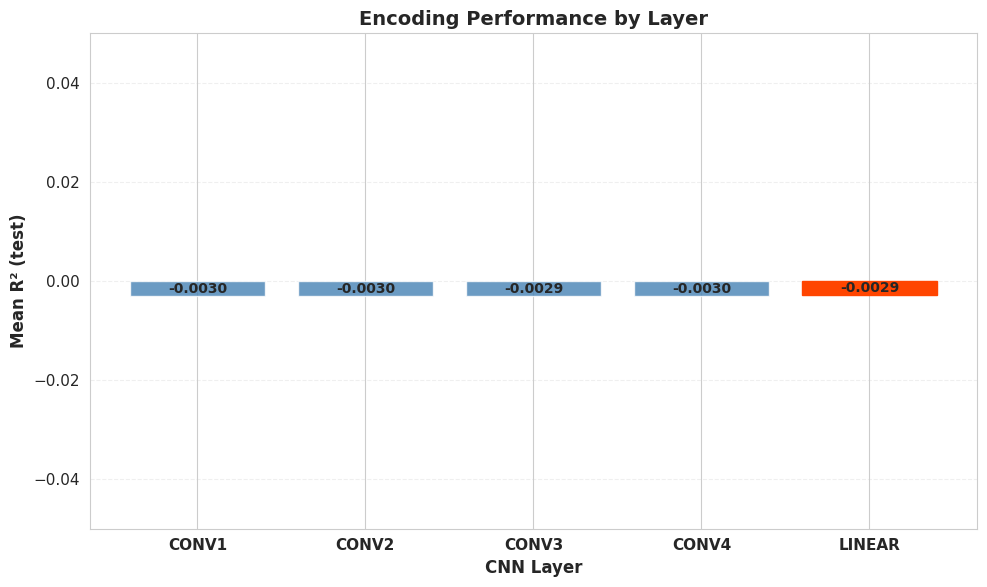

In [ ]:
# Compare layer performance

from encoding_utils import compare_layer_performance
from encoding_viz_utils import plot_layer_comparison_bars

comparison_df = compare_layer_performance(encoding_results)

print("Layer Performance:\n")
print("=" * 80)
print(comparison_df.to_string(index=False))
print("=" * 80)

best_layer = comparison_df.iloc[0]['layer']
best_r2 = comparison_df.iloc[0]['mean_r2']

print(f"\n⭐ Best: {best_layer.upper()} (R² = {best_r2:.4f})")

# Visualize
layer_order = ['conv1', 'conv2', 'conv3', 'conv4', 'linear']
fig = plot_layer_comparison_bars(encoding_results, layer_order)
plt.show()

Import necessary libraries and configure the environment.

Best layer: LINEAR



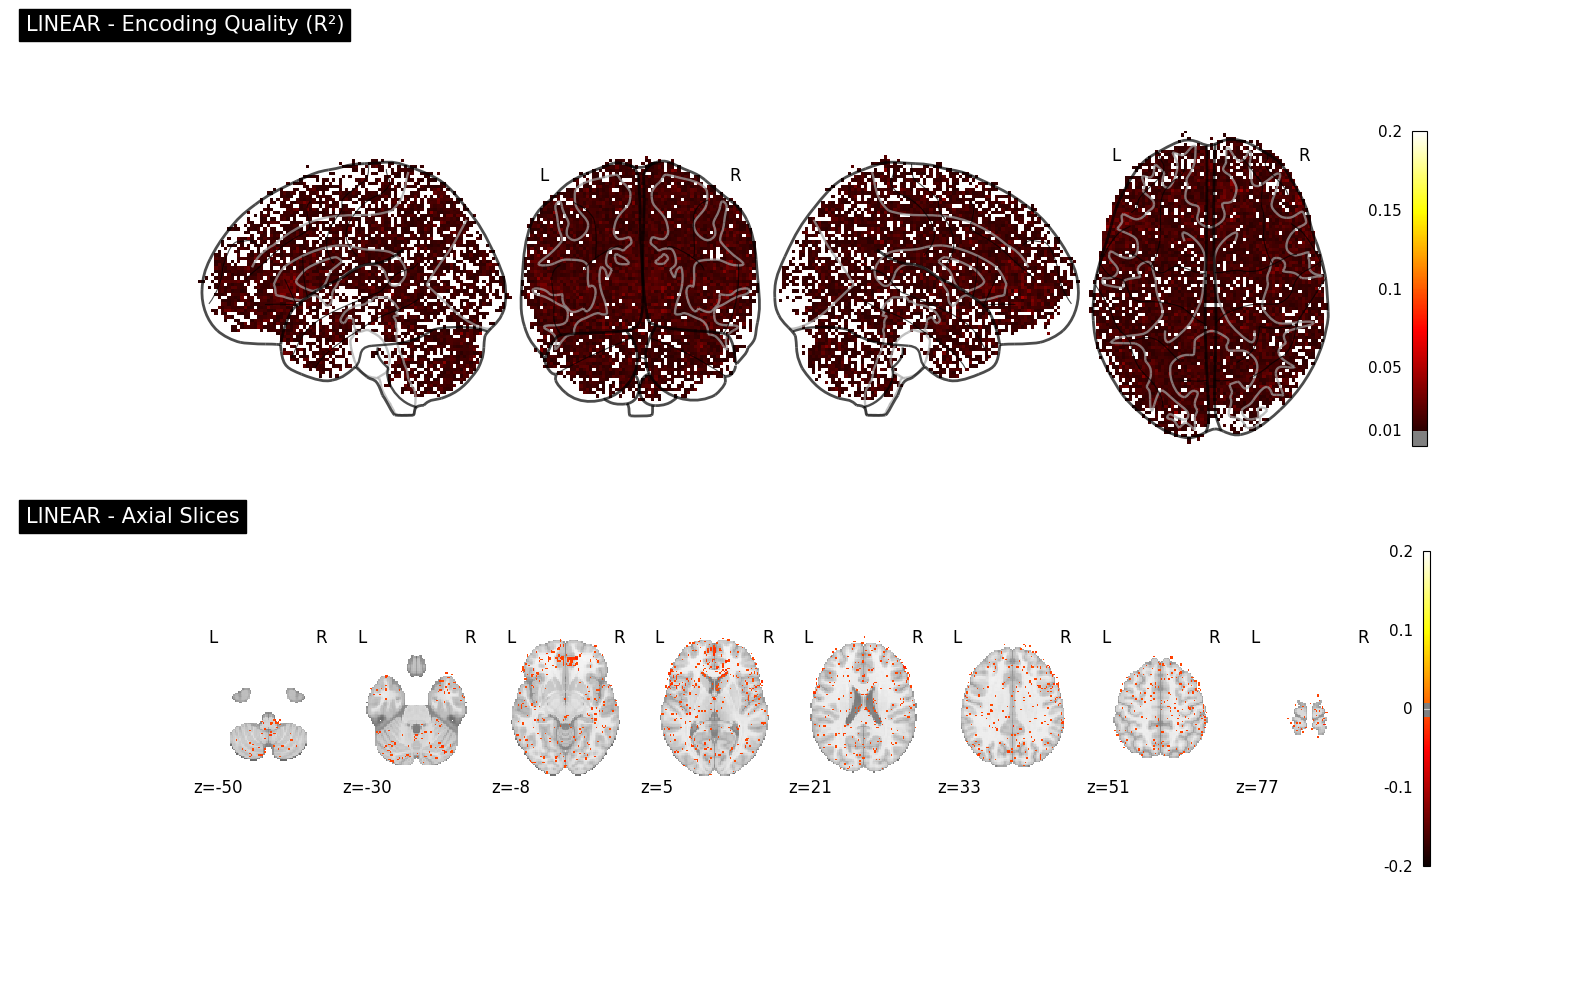


📍 Interpretation:
  Hot regions = Well predicted by this layer
  - Early layers → Visual cortex
  - Middle layers → Motor/parietal
  - Late layers → Frontal/executive


In [ ]:
# Visualize R² brain maps (best layer)

from encoding_viz_utils import plot_r2_brainmap

best_layer = comparison_df.iloc[0]['layer']
best_r2_map = encoding_results[best_layer]['r2_map']

print(f"Best layer: {best_layer.upper()}\n")

fig = plot_r2_brainmap(
    best_r2_map, 
    best_layer,
    threshold=0.01,
    vmax=0.2
)
plt.show()

print("\n📍 Interpretation:")
print("  Hot regions = Well predicted by this layer")
print("  - Early layers → Visual cortex")
print("  - Middle layers → Motor/parietal")
print("  - Late layers → Frontal/executive")